#### Facial Recognition with Different Feature Extractions 

Final Project for EN.601.675 Machine Learning

Author: Ruixin Li (rli57), Kejia Ren (kren6), Longji Yin (lyin10), Zhongyuan Zheng (zzheng34)

Link_to_git_repo: https://github.com/charlierkj/Facial-Recognition

### Project Introduction ###

Facial recognition is a very useful application which could be used in real world for purpose of identification, surveillance, etc. However, this task is still challenging since different human faces share very similar features and have large intra-class variations like illuminations, viewpoints, etc. We want to investigate how different machine learning models or feature extractors can help improve the performance for this task.

Specifically, our project is about investigating different feature extraction methods we have learned from class(e.g. PCA, LDA, LBP, etc) on human face recognition task, verifying their advances and better understanding their properties by experiment with several classifiers we have implemented in homeworks(e.g. k-NN and SVM). 

### Deliverables ###

### Completed Deliverables:

**Must accomplish**

  1.  Successfully load the image data from datasets to workspace, split the datasets to train/test sets, ie. implement the data loader.(in "**Dataset**" below)
  2.  Analyze the statistics of the data and visualize the distribution of data features and labels.(in "**Dataset**" below)
  3.  Apply PCA and LDA methods to do the feature extraction on image data.(in "**Feature Extraction**" below)
  4.  Train Support Vector Machine as the classifier on the training set, conduct hyperparameter sweep and test the classification resulton test image set.(in "**Classification**" below)
    
**Expect to accomplish**

  1.  Try ICA and LBP methods to do the feature extraction on image data.(in "**Feature Extraction**" below)
  2.  Try HoG method to do the feature extraction on image data.(in "**Feature Extraction**" below)
  3.  Train k-NN as the classifier on the training set, test the classification result on test image set.(in "**Classification**" below)
    
**Would like to accomplish**

  1.  Use advanced convolutional neural network, e.g. ResNet, to learn global and local features for classification.(in "**Classification**" below)
  2.  Compare the test accuracy using different feature extraction methods and classifiers combinations.(in "**Result**" below)
  3.  Evaluate the models using the comparison result and analyze the best method for this image analysis problem.(in "**Result**" below)

### Import related modules ###

Basically, we uses packages from Scikit-learn (https://scikit-learn.org/stable/), scikit-image (https://scikit-image.org/docs/dev/api/skimage.html) and PyTorch (https://pytorch.org/). Besides, we will also use our customized codes for better managing the whole project and more efficiently training and loading models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.utils.data as td

In [2]:
from dataset import ExtendedYaleFace
from features import *
from classifiers import *
from utils import *

## 1. Dataset ##

We use the cropped version of Extended Yale Face Database B (http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html), which contains 2414 centered grayscale images of 38 subjects, under 9 poses and 64 illumination conditions. The original resolution of the image is 192 (height) x 168 (width).

### 1.1. Original image ###

Original image shape is (192, 168)


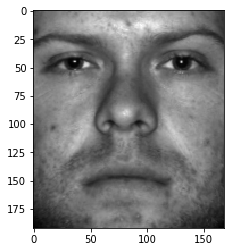

In [3]:
img = Image.open('data/CroppedYale/yaleB01/yaleB01_P00A+000E+00.pgm')
img = np.array(img)
print("Original image shape is", img.shape)
plt.imshow(img, cmap='gray')
plt.show()

### 1.2. Processed image loaded from our customized ExtendedYaleFace dataset ###

Total number of images in train set is 1931
Total number of images in test set is 483
Dimension of the batch data is torch.Size([4, 1, 32, 32])
Batch size is 4
Channel is 1
Image shape is resized to: torch.Size([32, 32])


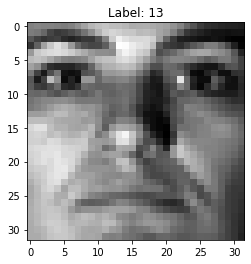

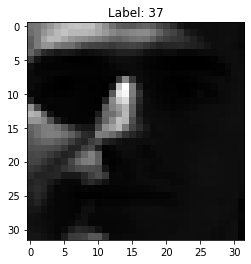

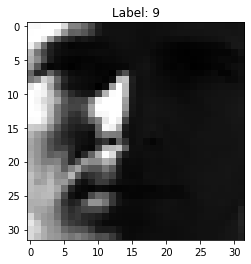

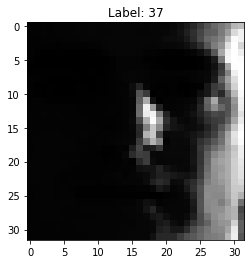

In [4]:
# dataset (unflattened, normalized to [-1, 1])
train_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, train=True)
test_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, test=True)
print("Total number of images in train set is", train_set.__len__())
print("Total number of images in test set is", test_set.__len__())

# dataloader
train_loader = td.DataLoader(train_set, batch_size=4, shuffle=False)
test_loader = td.DataLoader(test_set, batch_size=4, shuffle=False)

# visualize the first batch
for batch_idx, (image_batch, labels) in enumerate(train_loader):
    if batch_idx >= 1:
        break
    print("Dimension of the batch data is", image_batch.shape)
    print("Batch size is", image_batch.shape[0])
    print("Channel is", image_batch.shape[1])
    print("Image shape is resized to:", image_batch.shape[2:])
    for img_idx, img in enumerate(image_batch):
        plt.title("Label: %d" % labels[img_idx])
        plt.imshow(img.squeeze(0), cmap='gray')
        plt.show()

### 1.3. Dataset statistics ###

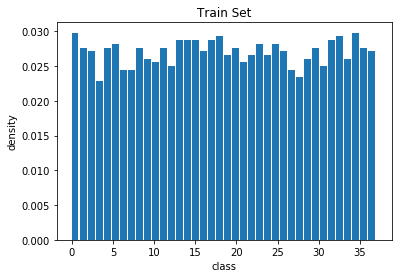

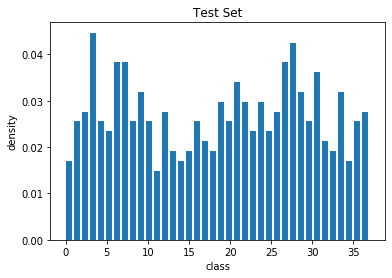

In [5]:
plt.hist(train_set.labels, bins=38, density=True, width=0.8)
plt.title("Train Set")
plt.xlabel("class")
plt.ylabel("density")
plt.show()

_, y_test = next(iter(test_loader))
plt.hist(test_set.labels, bins=38, density=True, width=0.8)
plt.title("Test Set")
plt.xlabel("class")
plt.ylabel("density")
plt.show()

## 2. Feature Extractions ##

In [6]:
# used to store different extracted features.
X_train = {}
y_train = train_set.labels
X_test = {}
y_test = test_set.labels

In [7]:
# dataset (flattened, normalized to [-1, 1])
train_set_flat = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=True, normalize=True, train=True)
test_set_flat = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=True, normalize=True, test=True)

### 2.1. Principle Component Analysis (PCA) ###

Dimension of the batch data is torch.Size([1931, 1, 1024])
Model saved to models/pca.pkl.


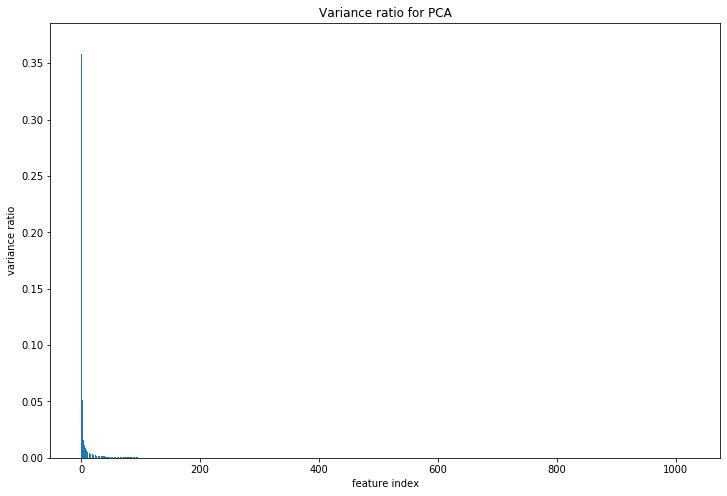

In [8]:
# fit PCA
pca = pca_fit(train_set_flat)
save_model(pca, "models/pca.pkl")
    
# plot variance ratio
plt.figure(figsize=(12, 8))
plt.title("Variance ratio for PCA")
plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("feature index")
plt.ylabel("variance ratio")
plt.show()

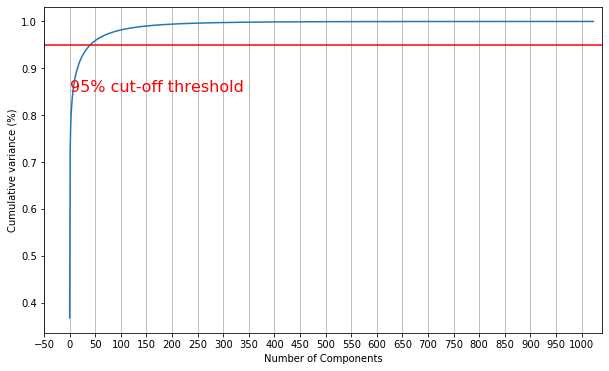

In [9]:
# Plot cumulative variance figure
plt.figure(figsize=(10,6))

cumulated_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(len(pca.explained_variance_ratio_)),cumulated_variance)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.grid(axis='x')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.xlim(-50, 1040)
locs, _ = plt.xticks(np.arange(-50,1050,50 ))

We select the top 50 components that can cover sufficiently much information of the image. And we show the top 10 components (eigenfaces) below for visualization.

Dimension of the batch data is torch.Size([1931, 1, 1024])
Dimension of the batch data is torch.Size([483, 1, 1024])


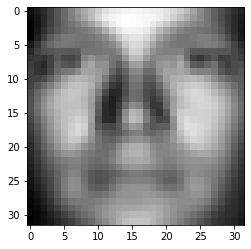

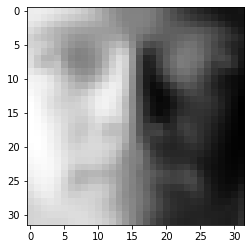

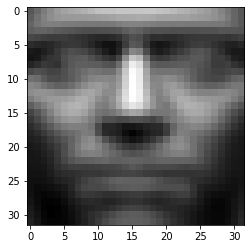

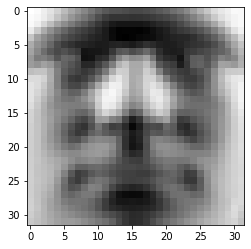

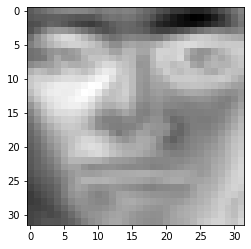

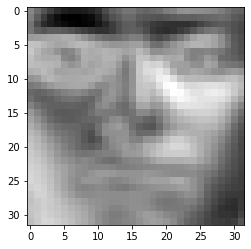

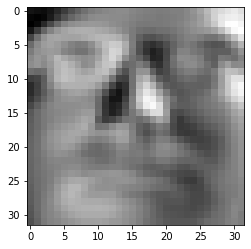

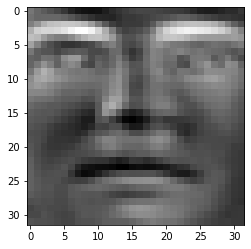

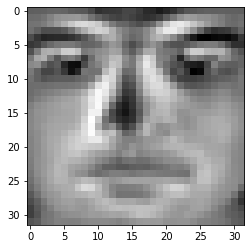

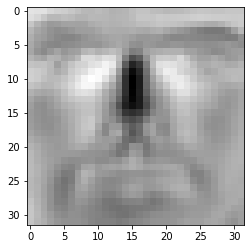

In [10]:
# store features
X_train['pca'] = pca_transform(pca, train_set_flat)[:, 0:50]
X_test['pca'] = pca_transform(pca, test_set_flat)[:, 0:50]

eigenfaces = pca.components_.reshape(-1, 32, 32)

for i in range(10):
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.show()

We test by reconstructing with the first 50 basis.

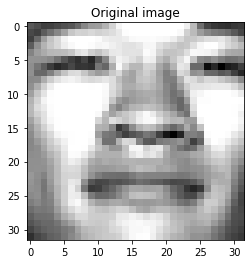

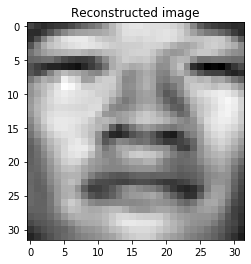

In [11]:
# original image
imgs, _ = next(iter(test_loader))
img_original = imgs[0]
plt.title("Original image")
plt.imshow(img_original.squeeze().numpy().reshape(32, 32), cmap='gray')
plt.show()

# reconstructed image
img_reconstructed = pca.mean_.reshape(32, 32)
for i in range(X_test['pca'].shape[1]):
    img_reconstructed += X_test['pca'][0, i] * eigenfaces[i]
plt.title("Reconstructed image")
plt.imshow(img_reconstructed, cmap='gray')
plt.show()

We then plot the t-SNE visualization for train set after PCA dimensionality reduction.

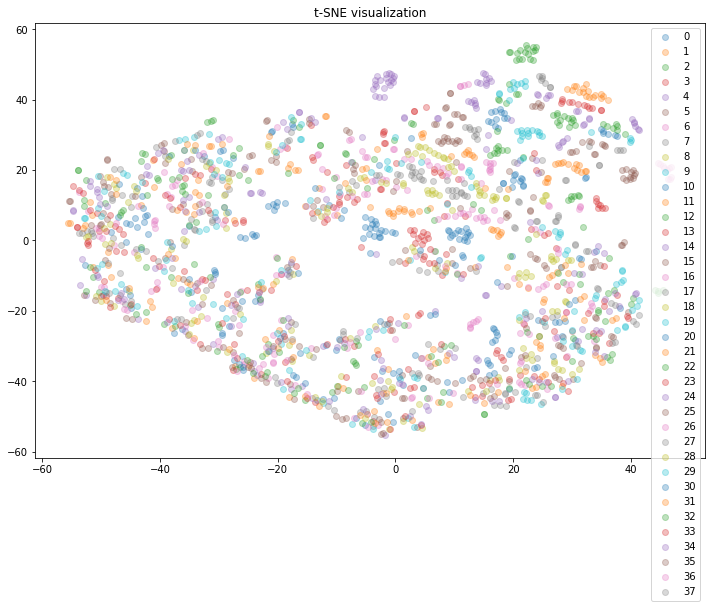

In [12]:
visualize_tsne(X_train['pca'], y_train)

### 2.2. Linear Discriminant Analysis (LDA) ###

Linear Discriminant Analysis(LDA) is a simple linear machine learning algorithm for classification. It works by calculating summary statistics for the input features by class label, such as the mean and standard deviation. 

After the model has been trained, predictions are made by estimating the probability that a new example belongs to each class label based on the values of each input feature


Dimension of the batch data is torch.Size([1931, 1, 1024])
Model saved to models/lda.pkl.
Dimension of the batch data is torch.Size([1931, 1, 1024])
Dimension of the batch data is torch.Size([483, 1, 1024])


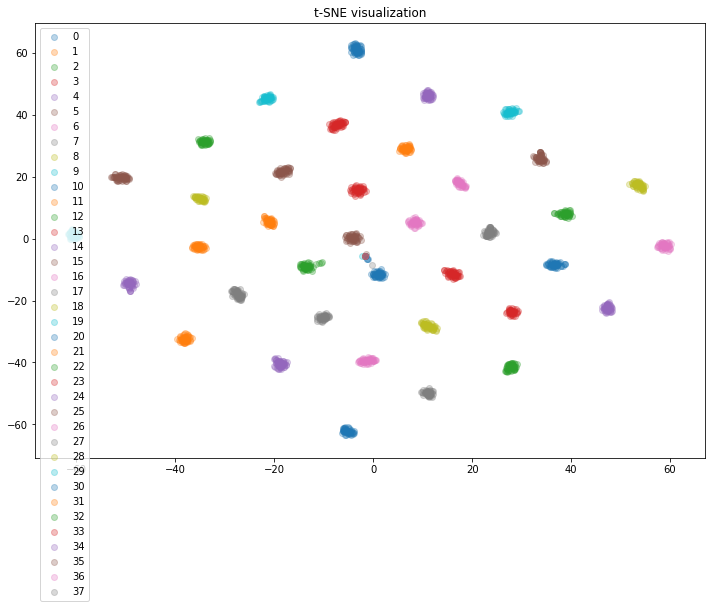

In [13]:
# fit LDA
lda = lda_fit(train_set_flat, 30)
save_model(lda, "models/lda.pkl")
    
# store features
X_train['lda'] = lda_transform(lda, train_set_flat)
X_test['lda'] = lda_transform(lda, test_set_flat)

# visualize t-SNE
visualize_tsne(X_train['lda'], y_train)

In [ ]:
# plot variance ratio for LDA
plt.figure(figsize=(12, 8))
plt.title("Variance ratio for LDA")
plt.bar(np.arange(len(lda.explained_variance_ratio_)), lda.explained_variance_ratio_)
plt.xlabel("feature index")
plt.ylabel("variance ratio")
plt.show()

In [ ]:
# plot overall features mean
plt.bar(np.arange(len(lda.xbar_)), height = lda.xbar_, width=0.8)
plt.title("LDA overall mean of all features")
plt.xlabel("Feature index")
plt.ylabel("Mean of feature")
plt.show()

### 2.3. Independent Component Analysis (ICA) ###

In [14]:
# fit ICA
ica, _ = ica_fit(train_set_flat)
save_model(ica, "models/ica.pkl")

Dimension of the batch data is torch.Size([1931, 1, 1024])
Model saved to models/ica.pkl.


We select the top 50 components that can cover sufficiently much information of the image. And we show the top 10 components (eigenfaces) below for visualization.

Dimension of the batch data is torch.Size([1931, 1, 1024])
Dimension of the batch data is torch.Size([483, 1, 1024])


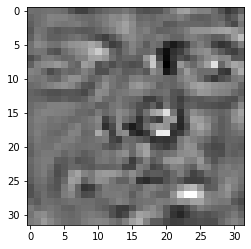

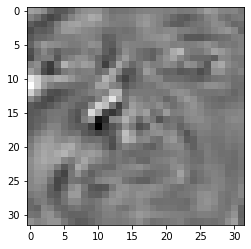

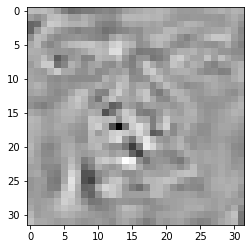

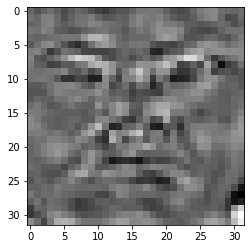

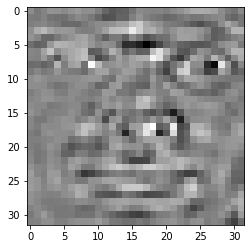

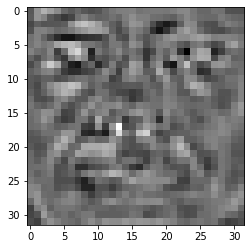

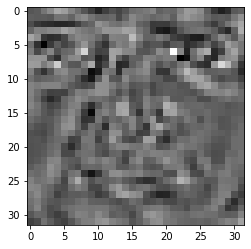

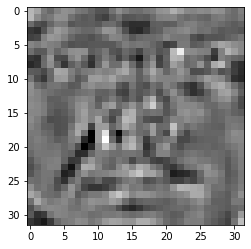

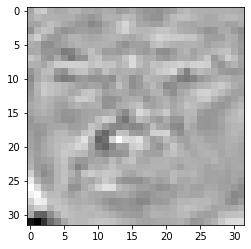

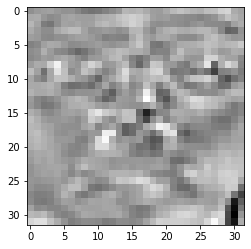

In [15]:
# store features
X_train['ica'] = ica_transform(ica, train_set_flat)
X_test['ica'] = ica_transform(ica, test_set_flat)

basis = ica.components_.reshape(-1, 32, 32)

for i in range(10):
    plt.imshow(basis[i], cmap='gray')
    plt.show()

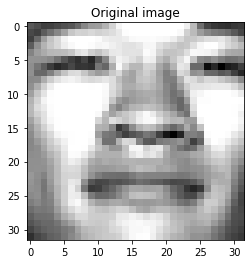

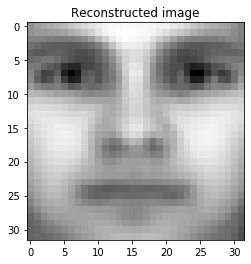

In [16]:
# original image
imgs, _ = next(iter(test_loader))
img_original = imgs[0]
plt.title("Original image")
plt.imshow(img_original.squeeze().numpy().reshape(32, 32), cmap='gray')
plt.show()

# reconstructed image
img_reconstructed = ica.mean_.reshape(32, 32)
for i in range(X_test['ica'].shape[1]):
    img_reconstructed += X_test['ica'][0, i] * basis[i]
plt.title("Reconstructed image")
plt.imshow(img_reconstructed, cmap='gray')
plt.show()

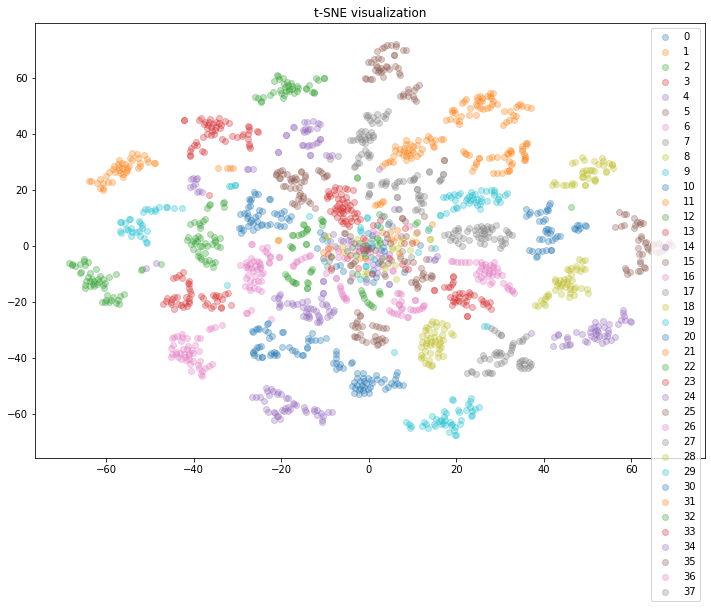

In [17]:
# visualize t-SNE
visualize_tsne(X_train['ica'], y_train)

### 2.4. Local Binary Pattern (LBP) ###

Local Binary Pattern (LBP) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number.

In [18]:
# transform
X_train_transformed, X_train_hists = lbp_transform(train_set)
X_test_transformed, X_test_hists = lbp_transform(test_set)

# store features
X_train['lbp'] = X_train_hists
X_test['lbp'] = X_test_hists

We visualize LBP and corresponding histogram

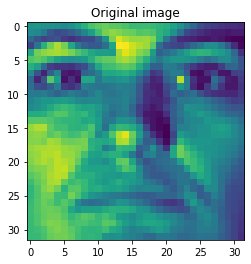

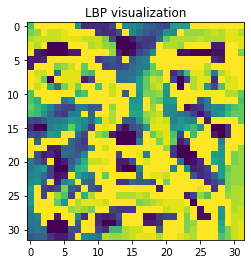

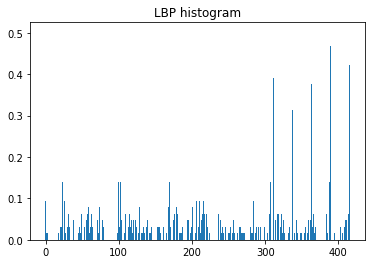

In [19]:
# original image
imgs, _ = next(iter(train_loader))
img_original = imgs[0]
plt.title("Original image")
plt.imshow(img_original.squeeze().numpy())
plt.show()

# LBP
plt.title("LBP visualization")
plt.imshow(X_train_transformed[0])
plt.show()

# histogram
plt.title("LBP histogram")
plt.bar(np.arange(len(X_train_hists[0])), X_train_hists[0], width=0.8)
plt.show()

### 2.5. Histogram of Gradient (HoG) ###

In [20]:
# transform
hog_train, hog_images_train = hog_transform(train_set)
hog_test, hog_images_test = hog_transform(test_set)

# store features
X_train['hog'] = hog_train
X_test['hog'] = hog_test

We visualize HoG image and the corresponding histogram plot

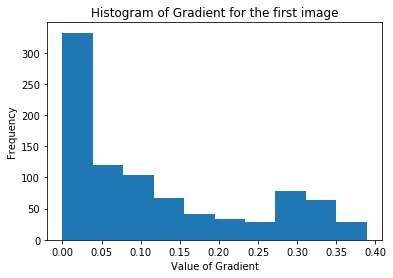

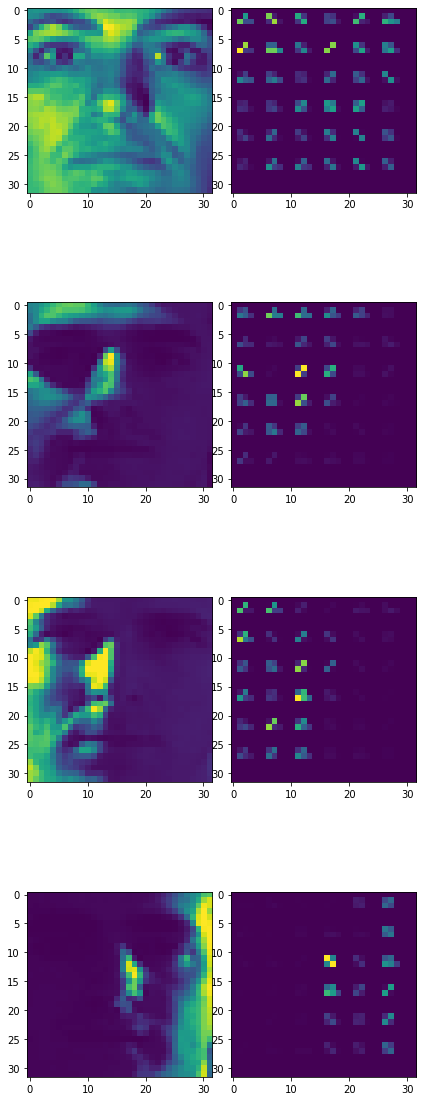

In [21]:
from skimage import exposure

# Histogram for first image
plt.hist(hog_train[0])
plt.title("Histogram of Gradient for the first image")
plt.ylabel("Frequency")
plt.xlabel("Value of Gradient")
plt.show()

# Plot first four image
image, _ = next(iter(train_loader))
for i in range(len(image)):
    plt.subplot(4,2,2*i+1)
    plt.imshow(image[i].squeeze().numpy())
    hog_image_rescale = exposure.rescale_intensity(hog_images_train[i], in_range=(0, 100))
    plt.subplot(4,2,2*i+2)
    plt.imshow(hog_image_rescale)
plt.subplots_adjust(left=0,top=4, bottom=0, hspace=0.1, wspace=0.1)

### 2.6. Directly use original image ###

In [22]:
train_loader_flat = td.DataLoader(train_set_flat, batch_size=train_set_flat.__len__(), shuffle=False)
test_loader_flat = td.DataLoader(test_set_flat, batch_size=test_set_flat.__len__(), shuffle=False)

for _, (x_train_org, y_train_org) in enumerate(train_loader_flat):
    x_train_org = x_train_org.squeeze().numpy()
    X_train['origin'] = x_train_org

for _, (x_test_org, y_test_org) in enumerate(test_loader_flat):
    x_test_org = x_test_org.squeeze().numpy()
    X_test['origin'] = x_test_org


## 3. Classifications ##

### 3.1. k-Nearest Neighbors (k-NN) ###

k-Nearest Neighbors (k-NN) works by finding the distances between a query and all the examples in the data, selecting the  (K) closest to the query, then votes for the most frequent label (in the case of classification) or averages the labels (in the case of regression).

An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors.

In [23]:
# evaluations
acc_train = []
acc_test = []

for k in X_train.keys():
    if k == 'origin':
        print("Train with original image:")
    else:
        print("Train with %s features:" % k)
    model_knn = train_knn(X_train[k], y_train)
    save_model(model_knn, "models/knn_%s.pth" % k)
    y_train_pred = model_knn.predict(X_train[k])
    y_test_pred = model_knn.predict(X_test[k])
    acc_train.append(np.mean(y_train_pred == y_train))
    acc_test.append(np.mean(y_test_pred == y_test))
    print("Accuracy on train set: %f" % np.mean(y_train_pred == y_train))
    print("Accuracy on test set: %f" % np.mean(y_test_pred == y_test))
    print("\n")

Train with pca features:
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Model saved to models/knn_pca.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.757764


Train with lda features:
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Model saved to models/knn_lda.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.933747


Train with ica features:
Best parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Model saved to models/knn_ica.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.908903


Train with lbp features:
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Model saved to models/knn_lbp.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.904762


Train with hog features:
Best parameters: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Model saved to models/knn_hog.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.857143


Train with original image:
Best paramet

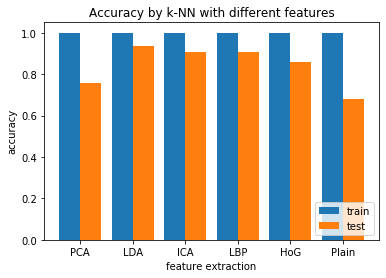

In [24]:
# plot
labels = ['PCA', 'LDA', 'ICA', 'LBP', 'HoG', 'Plain']

plt.title("Accuracy by k-NN with different features")
plt.bar(np.arange(len(acc_train))-0.2, acc_train, width=0.4, label="train")
plt.bar(np.arange(len(acc_test))+0.2, acc_test, width=0.4, label="test")
plt.xticks(np.arange(len(acc_test)), labels)
plt.xlabel("feature extraction")
plt.ylabel("accuracy")
plt.legend(loc=4)
plt.show()

### 3.2. Support Vector Machine (SVM) ###

In [ ]:
# evaluations
acc_train = []
acc_test = []

# initialize SVM agent
svm_agent = SVM_agent()

for k in X_train.keys():
    if k == 'origin':
        print("Train with original image:")
    else:
        print("Train with %s features:" % k)
    svm_agent.reset()
    svm_agent.hyper_tune(X_train[k], y_train)
    save_model(svm_agent.agent, "models/svm_%s.pth" % k)
    eval_train = svm_agent.test(X_train[k], y_train)
    eval_test = svm_agent.test(X_test[k], y_test)
    acc_train.append(eval_train)
    acc_test.append(eval_test)
    print("Accuracy on train set: %f" % eval_train)
    print("Accuracy on test set: %f" % eval_test)
    print("\n")

Train with pca features:
Best parameters: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Model saved to models/svm_pca.pth.
Accuracy on train set: 0.986018
Accuracy on test set: 0.931677


Train with lda features:
Best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Model saved to models/svm_lda.pth.
Accuracy on train set: 0.994821
Accuracy on test set: 0.931677


Train with ica features:
Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Model saved to models/svm_ica.pth.
Accuracy on train set: 0.990678
Accuracy on test set: 0.937888


Train with lbp features:
Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Model saved to models/svm_lbp.pth.
Accuracy on train set: 1.000000
Accuracy on test set: 0.933747


Train with hog features:
Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Model saved to models/svm_hog.pth.


In [ ]:
# plot
labels = ['PCA', 'LDA', 'ICA', 'LBP', 'HoG', 'Plain']

plt.title("Accuracy by SVM with different features")
plt.bar(np.arange(len(acc_train))-0.2, acc_train, width=0.4, label="train")
plt.bar(np.arange(len(acc_test))+0.2, acc_test, width=0.4, label="test")
plt.xticks(np.arange(len(acc_test)), labels)
plt.xlabel("feature extraction")
plt.ylabel("accuracy")
plt.legend(loc=4)
plt.show()

### 3.3. ResNet ###

In [ ]:
# train ResNet18
model_resnet = train_resnet(train_set, test_set)

# save and reload model
save_model(model_resnet, "models/resnet.pth")
model_resnet = load_model("models/resnet.pth")


